# 1.1 Activation Maximization

## Introduction

A deep neural network classifier mapping a set of data points or images $x$ to a set of classes $(\omega_c)_c$ models the conditional probability distribution $p(\omega_c | x)$. Therefore, a prototype $x^{*}$ can be found by optimizing the following objective:

$$\max_x \log p(\omega_c \, | \, x) - \lambda \lVert x\rVert^2$$

This can be achieved by first training a deep neural network and then performing gradient ascent on prepared prototype images. The rightmost term of the objective function ($\lambda \lVert x\rVert^2$) is an $l_2$-norm regularizer that prevents prototype images from deviating largely from the origin. Activation maximization is crude compared to other interpretation techniques and produces unnatural prototype images.

## Tensorflow Walkthrough

### 1. Import Dependencies

I created a separate module for DNN models. You can check out `models_1_1.py` in the models directory for more network details.

In [1]:
import os

from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from models.models_1_1 import MNIST_DNN

%matplotlib inline

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

logdir = './tf_logs/1_1_AM/'
ckptdir = logdir + 'model'

if not os.path.exists(logdir):
    os.mkdir(logdir)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### 2. Building Graph

In this step, a regular DNN classifier is initialized and necessary nodes for model training is added onto the graph.

In [2]:
with tf.name_scope('Classifier'):

    # Initialize neural network
    DNN = MNIST_DNN('DNN')

    # Setup training process
    lmda = tf.placeholder_with_default(0.01, shape=[], name='lambda')
    X = tf.placeholder(tf.float32, [None, 784], name='X')
    Y = tf.placeholder(tf.float32, [None, 10], name='Y')

    tf.add_to_collection('placeholders', lmda)

    logits = DNN(X)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

    optimizer = tf.train.AdamOptimizer().minimize(cost, var_list=DNN.vars)

    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

cost_summary = tf.summary.scalar('Cost', cost)
accuray_summary = tf.summary.scalar('Accuracy', accuracy)
summary = tf.summary.merge_all()

### 3. Building Subgraph for Generating Prototypes

Before training the network, a subgraph for generating prototypes is added onto the graph. This subgraph will be used after training the model.

In [3]:
with tf.name_scope('Prototype'):

    X_mean = tf.placeholder(tf.float32, [10, 784], name='X_mean')
    X_prototype = tf.get_variable('X_prototype', shape=[10, 784], initializer=tf.constant_initializer(0.))
    Y_prototype = tf.one_hot(tf.cast(tf.lin_space(0., 9., 10), tf.int32), depth=10)

    logits_prototype = DNN(X_prototype, reuse=True)

    # Objective function definition
    cost_prototype = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits_prototype, labels=Y_prototype)) \
                     + lmda * tf.nn.l2_loss(X_prototype - X_mean)

    optimizer_prototype = tf.train.AdamOptimizer().minimize(cost_prototype, var_list=[X_prototype])

# Add the subgraph nodes to a collection so that they can be used after training of the network
tf.add_to_collection('prototype', X_mean)
tf.add_to_collection('prototype', X_prototype)
tf.add_to_collection('prototype', Y_prototype)
tf.add_to_collection('prototype', logits_prototype)
tf.add_to_collection('prototype', cost_prototype)
tf.add_to_collection('prototype', optimizer_prototype)

Here's the general structure of the computation graph visualized using tensorboard.

![title](./assets/1_1_Activation_Maximization/graph.png)

### 4. Training Network

This is the step where the DNN is trained to classify the 10 digits of the MNIST images. Summaries are written into the logdir and you can visualize the statistics using tensorboard by typing this command: `tensorboard --lodir=./tf_logs`

In [4]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

# Hyper parameters
training_epochs = 15
batch_size = 100

for epoch in range(training_epochs):
    total_batch = int(mnist.train.num_examples / batch_size)
    avg_cost = 0
    avg_acc = 0
    
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        _, c, a, summary_str = sess.run([optimizer, cost, accuracy, summary], feed_dict={X: batch_xs, Y: batch_ys})
        avg_cost += c / total_batch
        avg_acc += a / total_batch
        
        file_writer.add_summary(summary_str, epoch * total_batch + i)

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost), 'accuracy =', '{:.9f}'.format(avg_acc))
    
    saver.save(sess, ckptdir)

print('Accuracy:', sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))

sess.close()

Epoch: 0001 cost = 0.235915433 accuracy = 0.931200002
Epoch: 0002 cost = 0.089025966 accuracy = 0.973109100
Epoch: 0003 cost = 0.058212864 accuracy = 0.981927283
Epoch: 0004 cost = 0.037602341 accuracy = 0.988036373
Epoch: 0005 cost = 0.030371556 accuracy = 0.990381826
Epoch: 0006 cost = 0.021637062 accuracy = 0.993490915
Epoch: 0007 cost = 0.018915237 accuracy = 0.994000006
Epoch: 0008 cost = 0.015711658 accuracy = 0.995127277
Epoch: 0009 cost = 0.014997141 accuracy = 0.995127277
Epoch: 0010 cost = 0.015114903 accuracy = 0.994981823
Epoch: 0011 cost = 0.012736740 accuracy = 0.995909095
Epoch: 0012 cost = 0.011209372 accuracy = 0.996545458
Epoch: 0013 cost = 0.009346475 accuracy = 0.996727276
Epoch: 0014 cost = 0.008826889 accuracy = 0.996781821
Epoch: 0015 cost = 0.009214011 accuracy = 0.996618185
Accuracy: 0.9813


### 5. Restoring Subgraph

Here we first rebuild the DNN graph from metagraph, restore DNN parameters from the checkpoint and then gather the necessary nodes for prototype generation using the `tf.get_collection()` function (recall prototype subgraph nodes were added onto the 'prototype' collection at step 3).

In [5]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

new_saver = tf.train.import_meta_graph(ckptdir + '.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(logdir))

# Get necessary placeholders
lmda = tf.get_collection('placeholders')[0]

# Get prototype nodes
prototype = tf.get_collection('prototype')
X_mean = prototype[0]
X_prototype = prototype[1]
cost_prototype = prototype[4]
optimizer_prototype = prototype[5]

INFO:tensorflow:Restoring parameters from ./tf_logs/1_1_AM/model


### 6. Generating Prototype Images

Before performing gradient ascent, we calculate the image means that will be used to regularize the prototype images. Then, we generate prototype images that maximize $\log p(\omega_c | x) - \lambda \lVert x\rVert^2$. I used 0.1 for lambda (lmda), but fine tuning may produce better prototype images.

In [6]:
images = mnist.train.images
labels = mnist.train.labels

img_means = []
for i in range(10):
    img_means.append(np.mean(images[np.argmax(labels, axis=1) == i], axis=0))

for epoch in range(5000):
    _, c = sess.run([optimizer_prototype, cost_prototype], feed_dict={lmda: 0.1, X_mean: img_means})
    
    if epoch % 500 == 0:
        print('Epoch: {:05d} Cost = {:.9f}'.format(epoch, c))
    
X_prototypes = sess.run(X_prototype)

sess.close()

Epoch: 00000 Cost = 25.786497116
Epoch: 00500 Cost = 2.708985567
Epoch: 01000 Cost = 0.190258697
Epoch: 01500 Cost = 0.012256578
Epoch: 02000 Cost = 0.005008637
Epoch: 02500 Cost = 0.004844339
Epoch: 03000 Cost = 0.004842392
Epoch: 03500 Cost = 0.004842398
Epoch: 04000 Cost = 0.004842440
Epoch: 04500 Cost = 0.004842412


### 7. Displaying Images

They are rather blurry; however, the results are pretty good. Feel free to play around with cmap and interpolation settings.

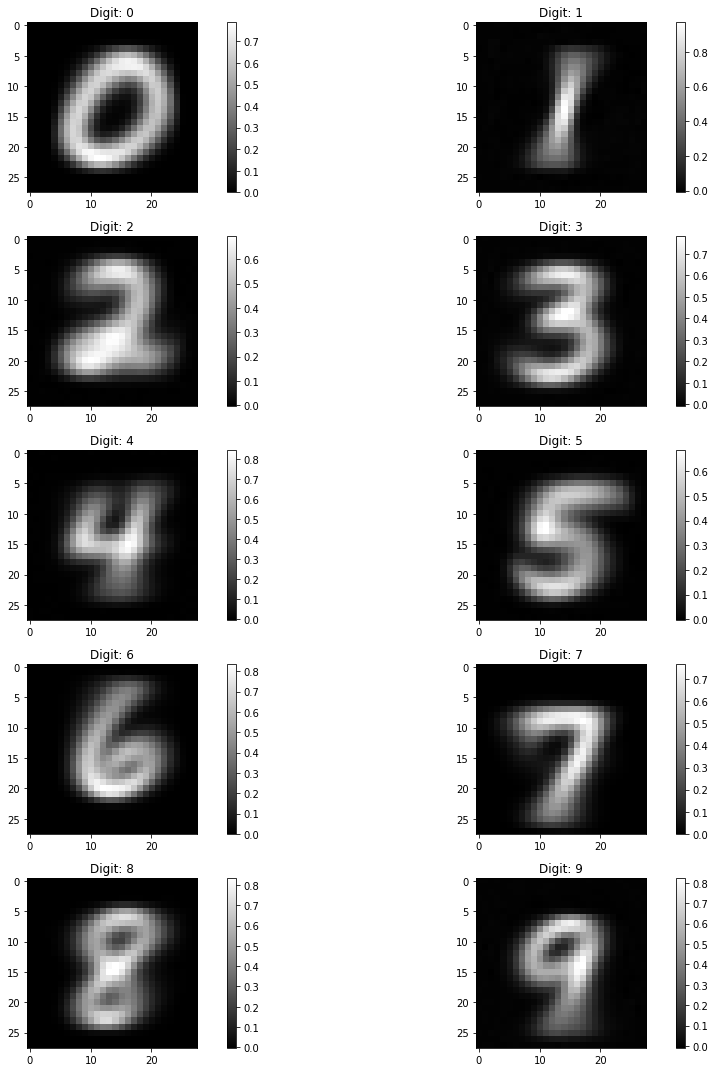

In [7]:
plt.figure(figsize=(15,15))
for i in range(5):
    plt.subplot(5, 2, 2 * i + 1)
    plt.imshow(np.reshape(X_prototypes[2 * i], [28, 28]), cmap='gray', interpolation='none')
    plt.title('Digit: {}'.format(2 * i))
    plt.colorbar()
    
    plt.subplot(5, 2, 2 * i + 2)
    plt.imshow(np.reshape(X_prototypes[2 * i + 1], [28, 28]), cmap='gray', interpolation='none')
    plt.title('Digit: {}'.format(2 * i + 1))
    plt.colorbar()

plt.tight_layout()